In this notebook, we will show you the differents steps to train step by step dly your model in this competition.

# Images Extractions

In [1]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
!wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_train.h5
!wget -q  https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_val.h5
!wget -q https://share.phys.ethz.ch/~pf/albecker/abc/09072022_1154_test.h5

In [6]:
trainset = h5py.File("09072022_1154_train.h5", "r")
validateset = h5py.File("09072022_1154_val.h5", "r")
testset = h5py.File("09072022_1154_test.h5", "r")

In [4]:
# attributes of trainset
trainset.keys()

<KeysViewHDF5 ['agbd', 'cloud', 'images', 'lat', 'lon', 'scl']>

## Explore datasets

In [5]:
# train
train_images = np.array(trainset['images'],dtype=np.float64)
train_images = train_images.transpose(0,3,1,2)

train_biomasses = np.array(trainset['agbd'],dtype=np.float64)

# validate
validate_images = np.array(validateset['images'],dtype=np.float64)
validate_images = validate_images.transpose(0,3,1,2)
validate_biomasses = np.array(validateset['agbd'],dtype=np.float64)

# test 
test_images = np.array(testset['images'],dtype=np.float32)
test_images = test_images.transpose(0,3,1,2)
test_biomasses = np.array(testset['agbd'],dtype=np.float32)

In [6]:
print(f"train dataset size {train_images.shape} train lab size {train_biomasses.shape}")
print()
print(f"validate dataset size {validate_images.shape} validate lab size {validate_biomasses.shape}")
print()
print(f"test dataset size {test_images.shape} test lab size {test_biomasses.shape}")

train dataset size (25036, 12, 15, 15) train lab size (25036,)

validate dataset size (5174, 12, 15, 15) validate lab size (5174,)

test dataset size (5190, 12, 15, 15) test lab size (5190,)


##  Some visulizations

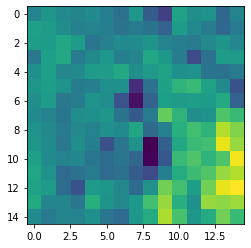

In [7]:
plt.imshow(train_images[1,1,:,:])

In [8]:
train_biomasses[1]

99.10187530517578

 **Below we explore the skewness of train dataset in each channel**

In [9]:
band_skewness = []
band_skewness_after_sqrt = []
for c in range(12):
    #calculate skewness
    band_skewness.append(pd.Series(train_images[:,c].flatten()).skew())
    #calculate skewness after applying sqrt
    band_skewness_after_sqrt.append(pd.Series(np.sqrt(train_images[:,c].flatten())).skew())

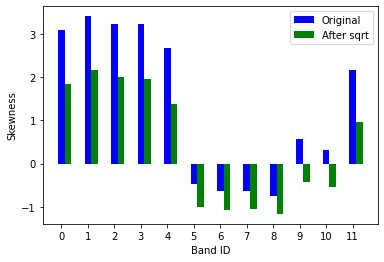

In [10]:
# skweness
width = 0.25

rng = [i for i in range(0,12)]
rng2 = [i+width for i in range(0,12)]

plt.bar(rng, band_skewness, align='center', width = width, label='Original', color ='b')
plt.bar(rng2, band_skewness_after_sqrt, align='center', width = width, label='After sqrt', color ='g')
plt.gca().set_xticks(rng)
plt.legend()
plt.xlabel('Band ID')
plt.ylabel('Skewness')
plt.show()

# First Baseline With Sklearn

In [11]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [12]:
from sklearn import set_config
set_config(display='diagram')

## Modelisation

### Pipeline of training

In [13]:
# constante for standardization
MEAN = train_images.mean((0,2,3))
STD = train_images.std((0,2,3))

In [14]:
class CustomScaler(BaseEstimator, TransformerMixin):
  def __init__(self,mean,std):
    self.mean = mean
    self.std = std
  
  def fit(self, X, y=None):
    #self.mean = X.mean((0,2,3)) 
    #self.std = X.std((0,2,3))
    return self

  def transform(self, X, y=None):
    return (X-self.mean[None,:,None,None])/self.std[None,:,None,None] 

    
class FlattenTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    return X.reshape((X.shape[0], -1))


pipe = Pipeline(steps=[("scaler", CustomScaler(MEAN,STD)),
                       ("flatten", FlattenTransformer()),
                       ("classifier", Lasso())
])

In [15]:
pipe.fit(train_images,train_biomasses)

Pipeline(steps=[('scaler',
                 CustomScaler(mean=array([ 644.62522678,  675.00465197,  887.51322647,  649.01398076,
       1230.65511708, 3005.58275568, 3717.91194245, 3626.2871387 ,
       3999.28166498, 4109.51322682, 2262.52644121, 1253.58153468]),
                              std=array([ 575.97684675,  570.30180631,  536.11125314,  550.22417005,
        557.76750885,  777.03590322,  935.15224447,  949.36012986,
        988.61001558, 1096.67397739,  671.68692054,  590.6012704 ]))),
                ('flatten', FlattenTransformer()), ('classifier', Lasso())])

In [16]:
# predict
pred_train = pipe.predict(train_images)

# train mse error
mse = mean_squared_error(train_biomasses, pred_train) 
mse
#rmse = np.sqrt(mse)

3023.555305378208

In [17]:
# predict
pred_validate = pipe.predict(validate_images)

#  validate mse error
mse = mean_squared_error(validate_biomasses, pred_validate) 
mse
#rmse = np.sqrt(mse)

3961.942859655493

### Gridsearch

In [ ]:
# Initiaze the hyperparameters for each dictionary
param1 = {}
param1['classifier'] = [LinearRegression()]

param2 = {}
param2['classifier__alpha'] = [0.1, 0.5, 1]
param2['classifier'] = [Ridge()]

param3 = {}
param3['classifier__alpha'] = [0.1, 0.5, 1]
param3['classifier'] = [Lasso()]

param4 = {}
param4['classifier__n_neighbors'] = [2,5,10,25,50]
param4['classifier'] = [KNeighborsRegressor()]

"""
param5 = {}
param5['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param5['classifier__epsilon'] = [0.0,0.2,0.5,1]
param5['classifier'] = [LinearSVR()]
"""

"\nparam5 = {}\nparam5['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]\nparam5['classifier__epsilon'] = [0.0,0.2,0.5,1]\nparam5['classifier'] = [LinearSVR()]\n"

In [ ]:
pipeline = pipe = Pipeline(steps=[("scaler", CustomScaler(MEAN,STD)),
                       ("flatten", FlattenTransformer()),
                       ("classifier", LinearRegression())])
params = [param1, param2, param3, param4] # param5


In [ ]:
# Train the grid search model
grid_search = GridSearchCV(pipeline, params, cv=3, scoring='neg_mean_squared_error').fit(train_images,train_biomasses)

In [ ]:
# Best performing model and its corresponding hyperparameters
grid_search.best_params_

In [ ]:
model = grid_search.best_estimator_
# predict
pred = model.predict(train_images)

# validate mse error
mse = mean_squared_error(train_biomasses, pred) 
rmse = np.sqrt(mse)

print(mse, rmse)

In [ ]:
model = grid_search.best_estimator_
# predict
pred = model.predict(validate_images)

# validate mse error
mse = mean_squared_error(validate_biomasses, pred) 
rmse = np.sqrt(mse)

print(mse, rmse)

### Predict GIZ Biomass

In [18]:
s2_images_h5 = h5py.File("/content/images_test.h5", "r")

In [19]:
#prepare test set sentinel 2 images 
s2_images = np.array(s2_images_h5["images"])
s2_images = s2_images.transpose(0,3,1,2)

In [20]:
# predict on giz test data
pred_giz = pipe.predict(s2_images)

In [21]:
ID_S2_pair = pd.read_csv('/content/UniqueID-SentinelPair.csv')

preds = pd.DataFrame({'Target':pred_giz}).rename_axis('S2_idx').reset_index()
preds = ID_S2_pair.merge(preds, on='S2_idx').drop(columns=['S2_idx'])

In [23]:
preds.to_csv('GIZ_Biomass_predictions.csv', index=False)

In [22]:
preds

,ID,Target
0,ID_1EB0DGFP07,26.220862
1,ID_844T2PSXTK,39.863222
2,ID_4MCV3S8MLN,39.037564
3,ID_L7441JV5F3,41.643822
4,ID_5GUVM4YEWZ,42.443223
...,...,...
85,ID_MEW6189J1B,54.941441
86,ID_TH9HRUXGTP,47.551169
87,ID_GPC7YS3JG8,55.395363
88,ID_1P7PJMPV0R,35.624857
